# Лабораторная работа №4 (Проведение исследований со случайным лесом)

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from phik.report import plot_correlation_matrix
pd.set_option('display.max_columns', None)

## Часть 1: Выбор начальных условий

### Набор данных для классификации

In [3]:
data = pd.read_csv("../data_sets/gym_members_exercise_tracking.csv")

In [4]:
data.head()

Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
0                      1.69           1313.0         Yoga            12.6   
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0                    3.5                              4                 3   
1                    2.1                              4                 2   
2                    2.3                              4                 2   
3                    2.1                              3                 1   
4                    2.8                              3                 1   

     BMI  
0  30.20  
1  32.00  
2  24.71  
3  18.41  
4  14.39

### Описание фичей:

- Age: возраст посетителя тренажерного зала.
- Gender: пол посетителя тренажерного зала (мужчина или женщина).
- Weight (kg): вес участника в килограммах.
- Height (m): рост участника в метрах.
- Max_BPM: максимальная частота сердечных сокращений (ударов в минуту) во время тренировок.
- Avg_BPM: средняя частота сердечных сокращений во время тренировок.
- Resting_BPM: частота сердечных сокращений в состоянии покоя перед тренировкой.
- Session_Duration (hours): продолжительность каждой тренировки в часах.
- Calories_Burned: общее количество сожженных калорий за каждую тренировку.
- Workout_Type: Тип выполняемой тренировки (например, кардио, силовая, йога, HIIT).
- Fat_Percentage: процентное содержание жира в организме участника.
- Water_Intake (liters): ежедневное потребление воды во время тренировок.
- Workout_Frequency (days/week): количество тренировок в неделю.
- Experience_Level: уровень опыта, от новичка (1) до эксперта (3).
- BMI: индекс массы тела, рассчитываемый исходя из роста и веса.

#### Разобьем на категориальные и числовые колонки

In [5]:
# Категориальные колонки
categorical_columns = [
    'Workout_Type', 'Experience_Level'
]

# Колонка-таргет
target_columns = 'Gender'

# Числовые колонки
numerical_columns = data.columns[~data.columns.isin(categorical_columns + [target_columns])].tolist()

Превратим object в числовые значения и укажем явно, что это категориальный тип данных

In [6]:
data = pd.get_dummies(data, columns=["Workout_Type"], prefix="Workout_Type")

label_encoder = {"Gender": LabelEncoder()}
data["Gender"] = label_encoder["Gender"].fit_transform(data["Gender"])

In [7]:
data.head()

Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56       1         88.3        1.71      180      157           60   
1   46       0         74.9        1.53      179      151           66   
2   32       0         68.1        1.66      167      122           54   
3   25       1         53.2        1.70      190      164           56   
4   38       1         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
0                      1.69           1313.0            12.6   
1                      1.30            883.0            33.9   
2                      1.11            677.0            33.4   
3                      0.59            532.0            28.8   
4                      0.64            556.0            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0                    3.5                              4                 3   
1                    2.1                              4                 2   
2                    2.3                              4                 2   
3                    2.1                              3                 1   
4                    2.8                              3                 1   

     BMI  Workout_Type_Cardio  Workout_Type_HIIT  Workout_Type_Strength  \
0  30.20                False              False                  False   
1  32.00                False               True                  False   
2  24.71                 True              False                  False   
3  18.41                False              False                   True   
4  14.39                False              False                   True   

   Workout_Type_Yoga  
0               True  
1              False  
2              False  
3              False  
4              False

In [8]:
categorical_columns = ["Workout_Type_Cardio", "Workout_Type_HIIT", "Workout_Type_Strength", "Workout_Type_Yoga", "Experience_Level"]

In [9]:
data[categorical_columns + [target_columns]] = data[categorical_columns + [target_columns]].astype('category')

Разобьем выборку на трэин и валидацию

In [10]:
train, valid = train_test_split(data, train_size=0.8, random_state=42, shuffle=True, stratify=data[target_columns])

In [11]:
X_train = train.drop(columns=target_columns, inplace=False)
y_train = train[target_columns]

X_valid = valid.drop(columns=target_columns, inplace=False)
y_valid = valid[target_columns]

- В качестве датасета для классификации я взял показатели физической подготовки и физических характеристик
- Таргет - Gender: пол
- В качестве метрики качества буду использовать F1-score, тк хорошая метрика для классификации, учитывающая точность и полноту, Balanced Accuracy, тк она проще всего для понимания и учитывает дисбаланс классов, и в отдельности Precision и Recall

## Часть 2: Создание бейзлайна и оценка качества

### A: Обучение модели

Для начала сделаем препроцессор и закинем его вместе с pipeline в модель

In [12]:
model = RandomForestClassifier()

Обучаем модель

In [13]:
model.fit(X_train, y_train)

RandomForestClassifier()

Делаем предсказания по тренировочной выборке и валидационной

In [14]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### B: Оценка качества модели

In [15]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict)
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro')
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict)
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro')
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [16]:
metrics_df.head()

Метрика  Тренировочная выборка  Валидационная выборка
0                 F1                    1.0               0.995074
1  Balanced Accuracy                    1.0               0.995098
2          Precision                    1.0               0.994681
3             Recall                    1.0               0.995098

Визуализируем метрики

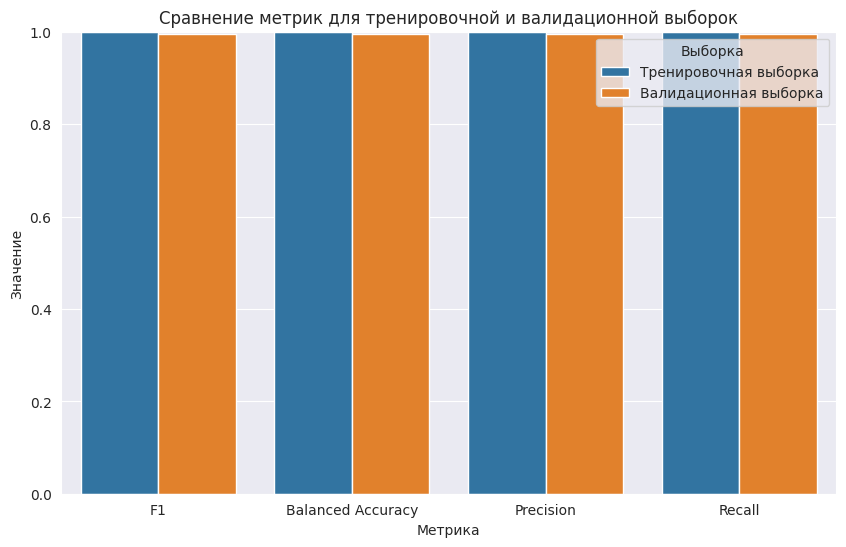

In [17]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

Как видим, качество модели получше чем у k ближайших, но ее стоит дорабатывать

## Улучшение бейзлайна

In [18]:
train.head()

Age Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
22    50      0         71.0        1.68      187      161           70   
749   28      0         79.6        1.59      181      130           54   
551   30      1        113.4        1.91      177      137           54   
183   19      1         87.8        1.78      195      161           72   
277   50      1         51.5        1.71      199      155           64   

     Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
22                       1.17            848.0            33.1   
749                      1.49            968.0            28.2   
551                      1.27            957.0            22.2   
183                      1.28           1133.0            23.6   
277                      1.48           1136.0            20.9   

     Water_Intake (liters)  Workout_Frequency (days/week) Experience_Level  \
22                     2.5                              2                1   
749                    1.5                              3                2   
551                    3.7                              3                1   
183                    3.3                              2                1   
277                    2.9                              2                1   

       BMI Workout_Type_Cardio Workout_Type_HIIT Workout_Type_Strength  \
22   25.16               False             False                 False   
749  31.49               False              True                 False   
551  31.08               False              True                 False   
183  27.71                True             False                 False   
277  17.61               False             False                 False   

    Workout_Type_Yoga  
22               True  
749             False  
551             False  
183             False  
277              True

In [19]:
y_train.value_counts()

Gender
1    409
0    369
Name: count, dtype: int64

#### Определим кол-во пустых значений в каждой фиче

In [20]:
data.isna().sum()

Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
Workout_Type_Cardio              0
Workout_Type_HIIT                0
Workout_Type_Strength            0
Workout_Type_Yoga                0
dtype: int64

Пустых значений нет

### Проверим на выбросы Gender и посмотрим кол-во каждых значений

In [21]:
train.nunique()

Age                               42
Gender                             2
Weight (kg)                      476
Height (m)                        51
Max_BPM                           40
Avg_BPM                           50
Resting_BPM                       25
Session_Duration (hours)         146
Calories_Burned                  543
Fat_Percentage                   228
Water_Intake (liters)             23
Workout_Frequency (days/week)      4
Experience_Level                   3
BMI                              636
Workout_Type_Cardio                2
Workout_Type_HIIT                  2
Workout_Type_Strength              2
Workout_Type_Yoga                  2
dtype: int64

В Gender нет выбросов

### Выведем основные характеристики фичей

In [22]:
numeric_stats = train.select_dtypes(include=['number']).describe()
categorical_stats = train.select_dtypes(include=['category', 'object']).describe()

In [23]:
numeric_stats

Age  Weight (kg)  Height (m)     Max_BPM     Avg_BPM  \
count  778.000000   778.000000  778.000000  778.000000  778.000000   
mean    38.359897    74.507455    1.727442  179.791774  144.367609   
std     12.209625    21.388131    0.124711   11.717847   14.408495   
min     18.000000    40.000000    1.500000  160.000000  120.000000   
25%     28.000000    58.825000    1.630000  170.000000  132.000000   
50%     39.000000    70.250000    1.720000  180.000000  144.000000   
75%     49.000000    86.475000    1.800000  190.000000  157.000000   
max     59.000000   129.900000    2.000000  199.000000  169.000000   

       Resting_BPM  Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
count   778.000000                778.000000       778.000000      778.000000   
mean     62.340617                  1.243188       900.537275       25.121208   
std       7.280794                  0.341173       270.468271        6.212277   
min      50.000000                  0.500000       303.000000       10.000000   
25%      56.000000                  1.030000       719.000000       21.300000   
50%      62.500000                  1.250000       886.000000       26.400000   
75%      68.000000                  1.430000      1071.750000       29.400000   
max      74.000000                  2.000000      1783.000000       35.000000   

       Water_Intake (liters)  Workout_Frequency (days/week)         BMI  
count             778.000000                     778.000000  778.000000  
mean                2.621851                       3.303342   24.964614  
std                 0.595293                       0.902172    6.642893  
min                 1.500000                       2.000000   12.320000  
25%                 2.200000                       3.000000   20.217500  
50%                 2.600000                       3.000000   24.080000  
75%                 3.100000                       4.000000   28.455000  
max                 3.700000                       5.000000   49.840000

In [24]:
categorical_stats

Gender  Experience_Level Workout_Type_Cardio Workout_Type_HIIT  \
count      778               778                 778               778   
unique       2                 3                   2                 2   
top          1                 2               False             False   
freq       409               325                 579               601   

       Workout_Type_Strength Workout_Type_Yoga  
count                    778               778  
unique                     2                 2  
top                    False             False  
freq                     572               582

#### Кол-во дубликатов

In [25]:
sum(train.duplicated())

0

Дубликатов нет

### Визуализируем данные

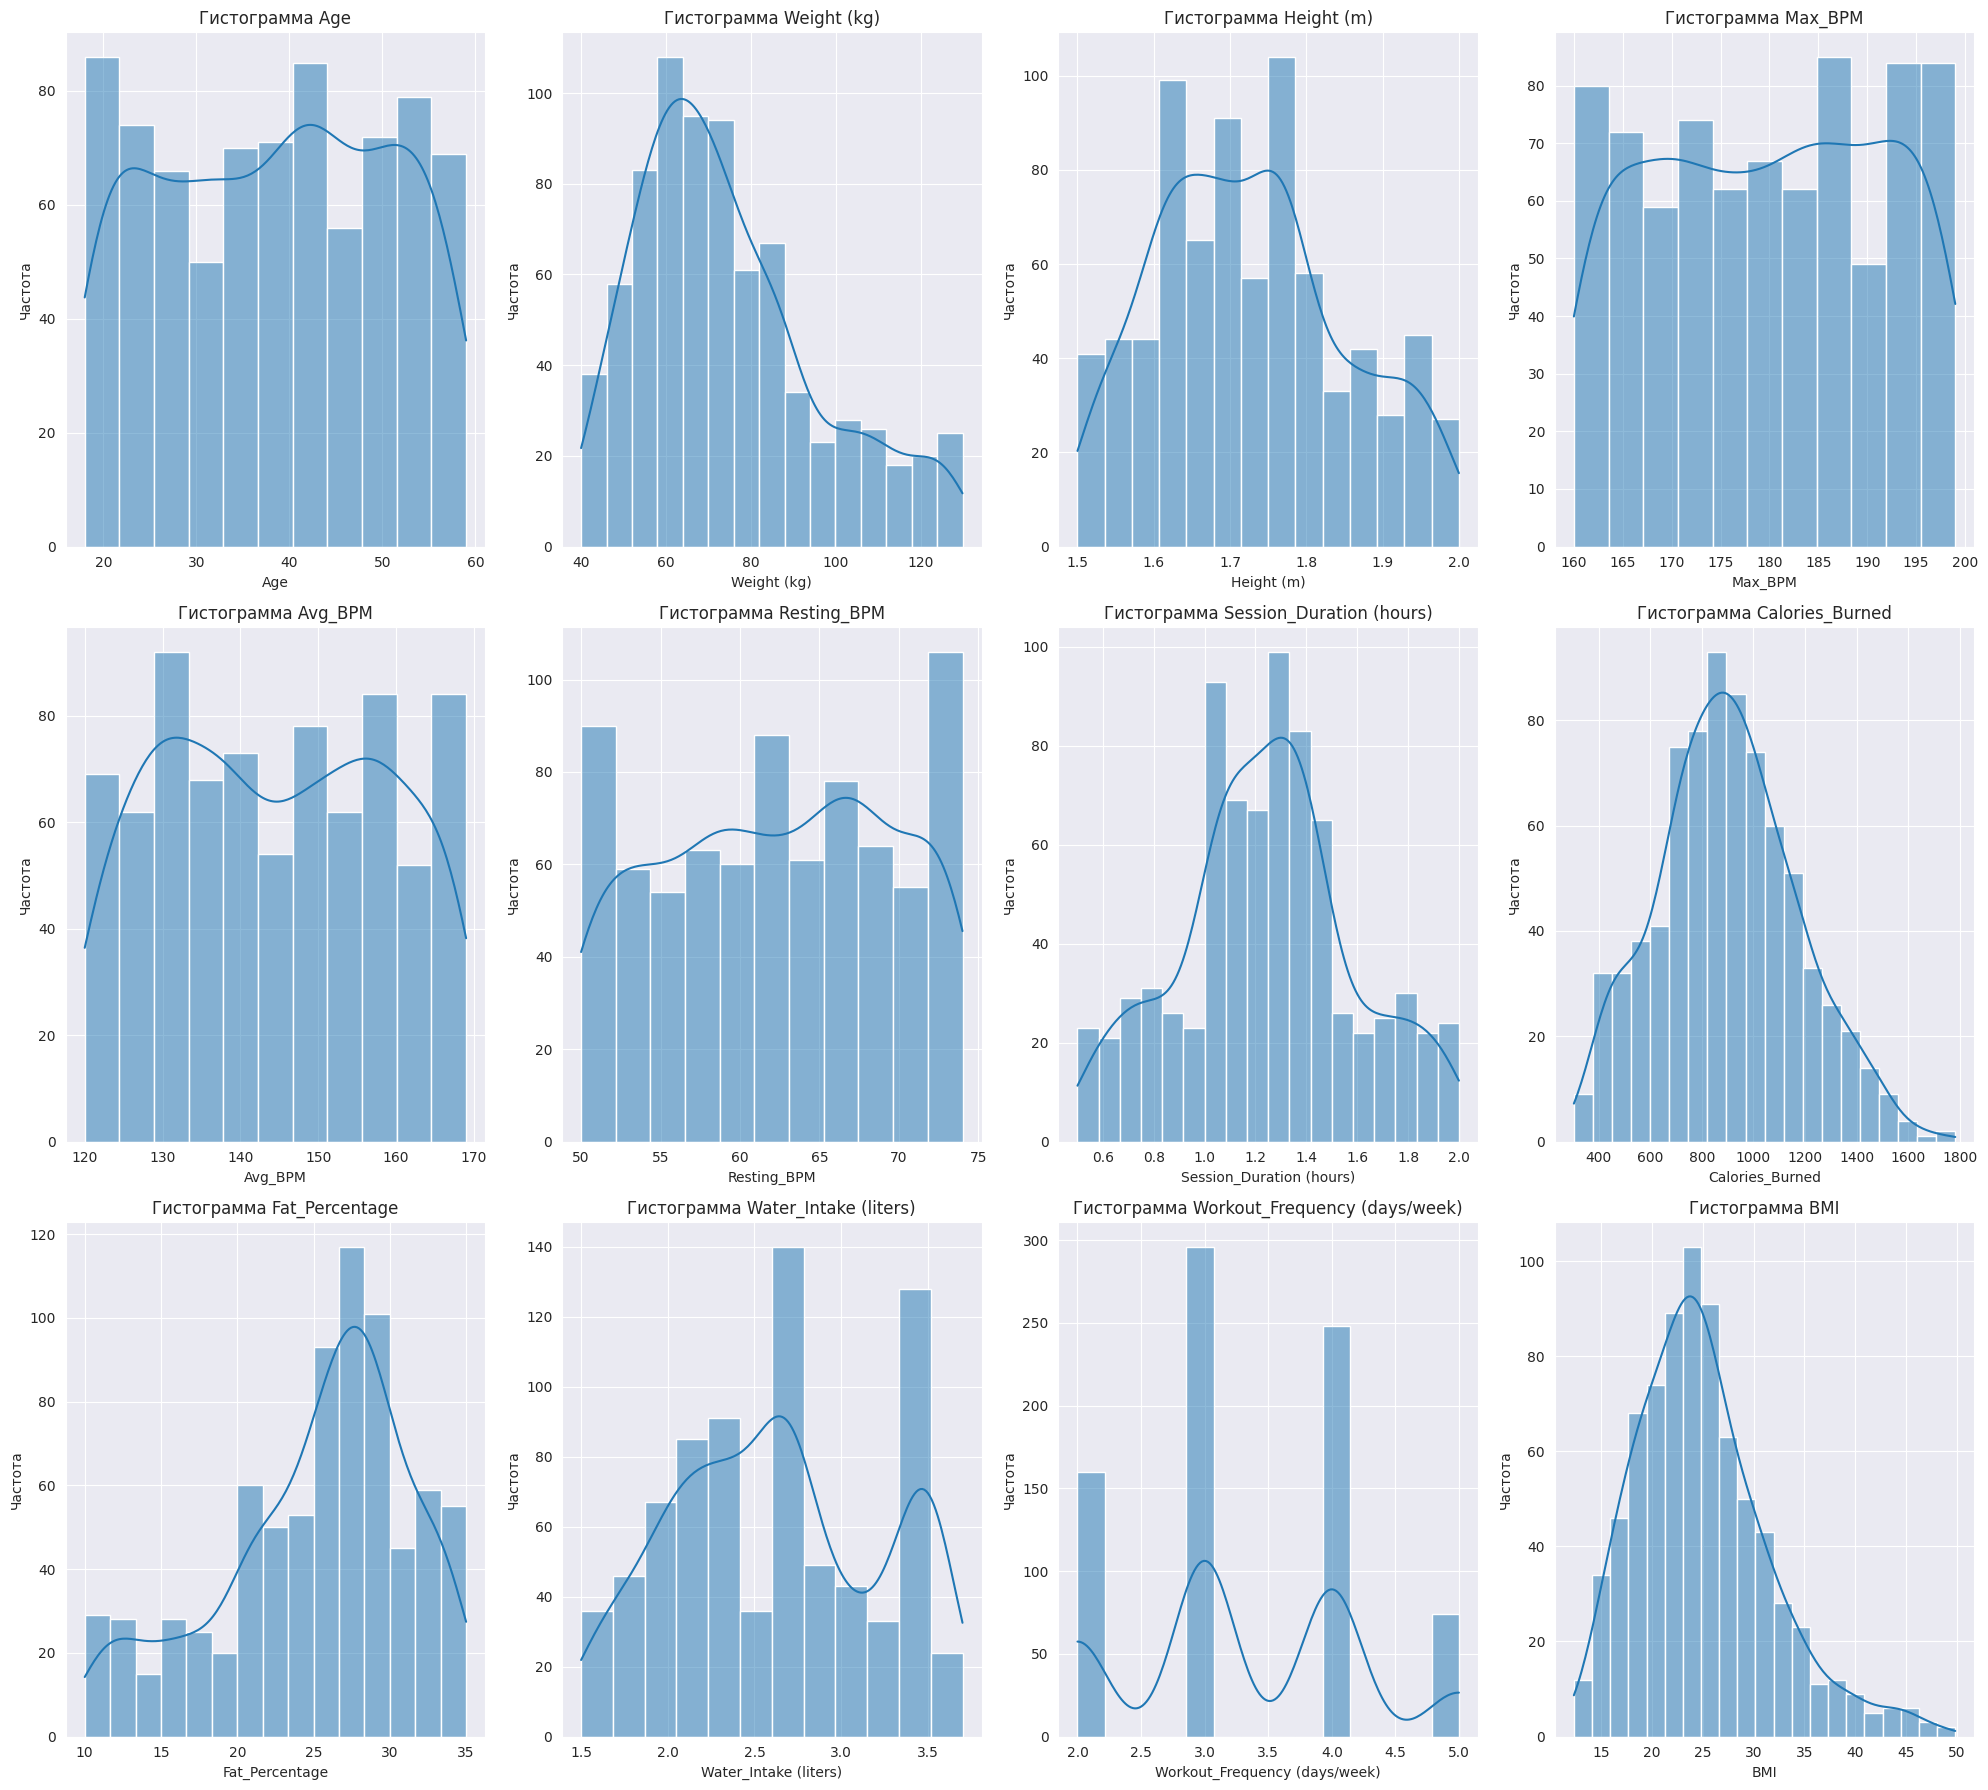

In [26]:
n_cols = 4
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    sns.histplot(train[col], kde=True, ax=axes[idx])
    axes[idx].set_title(f'Гистограмма {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')

for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

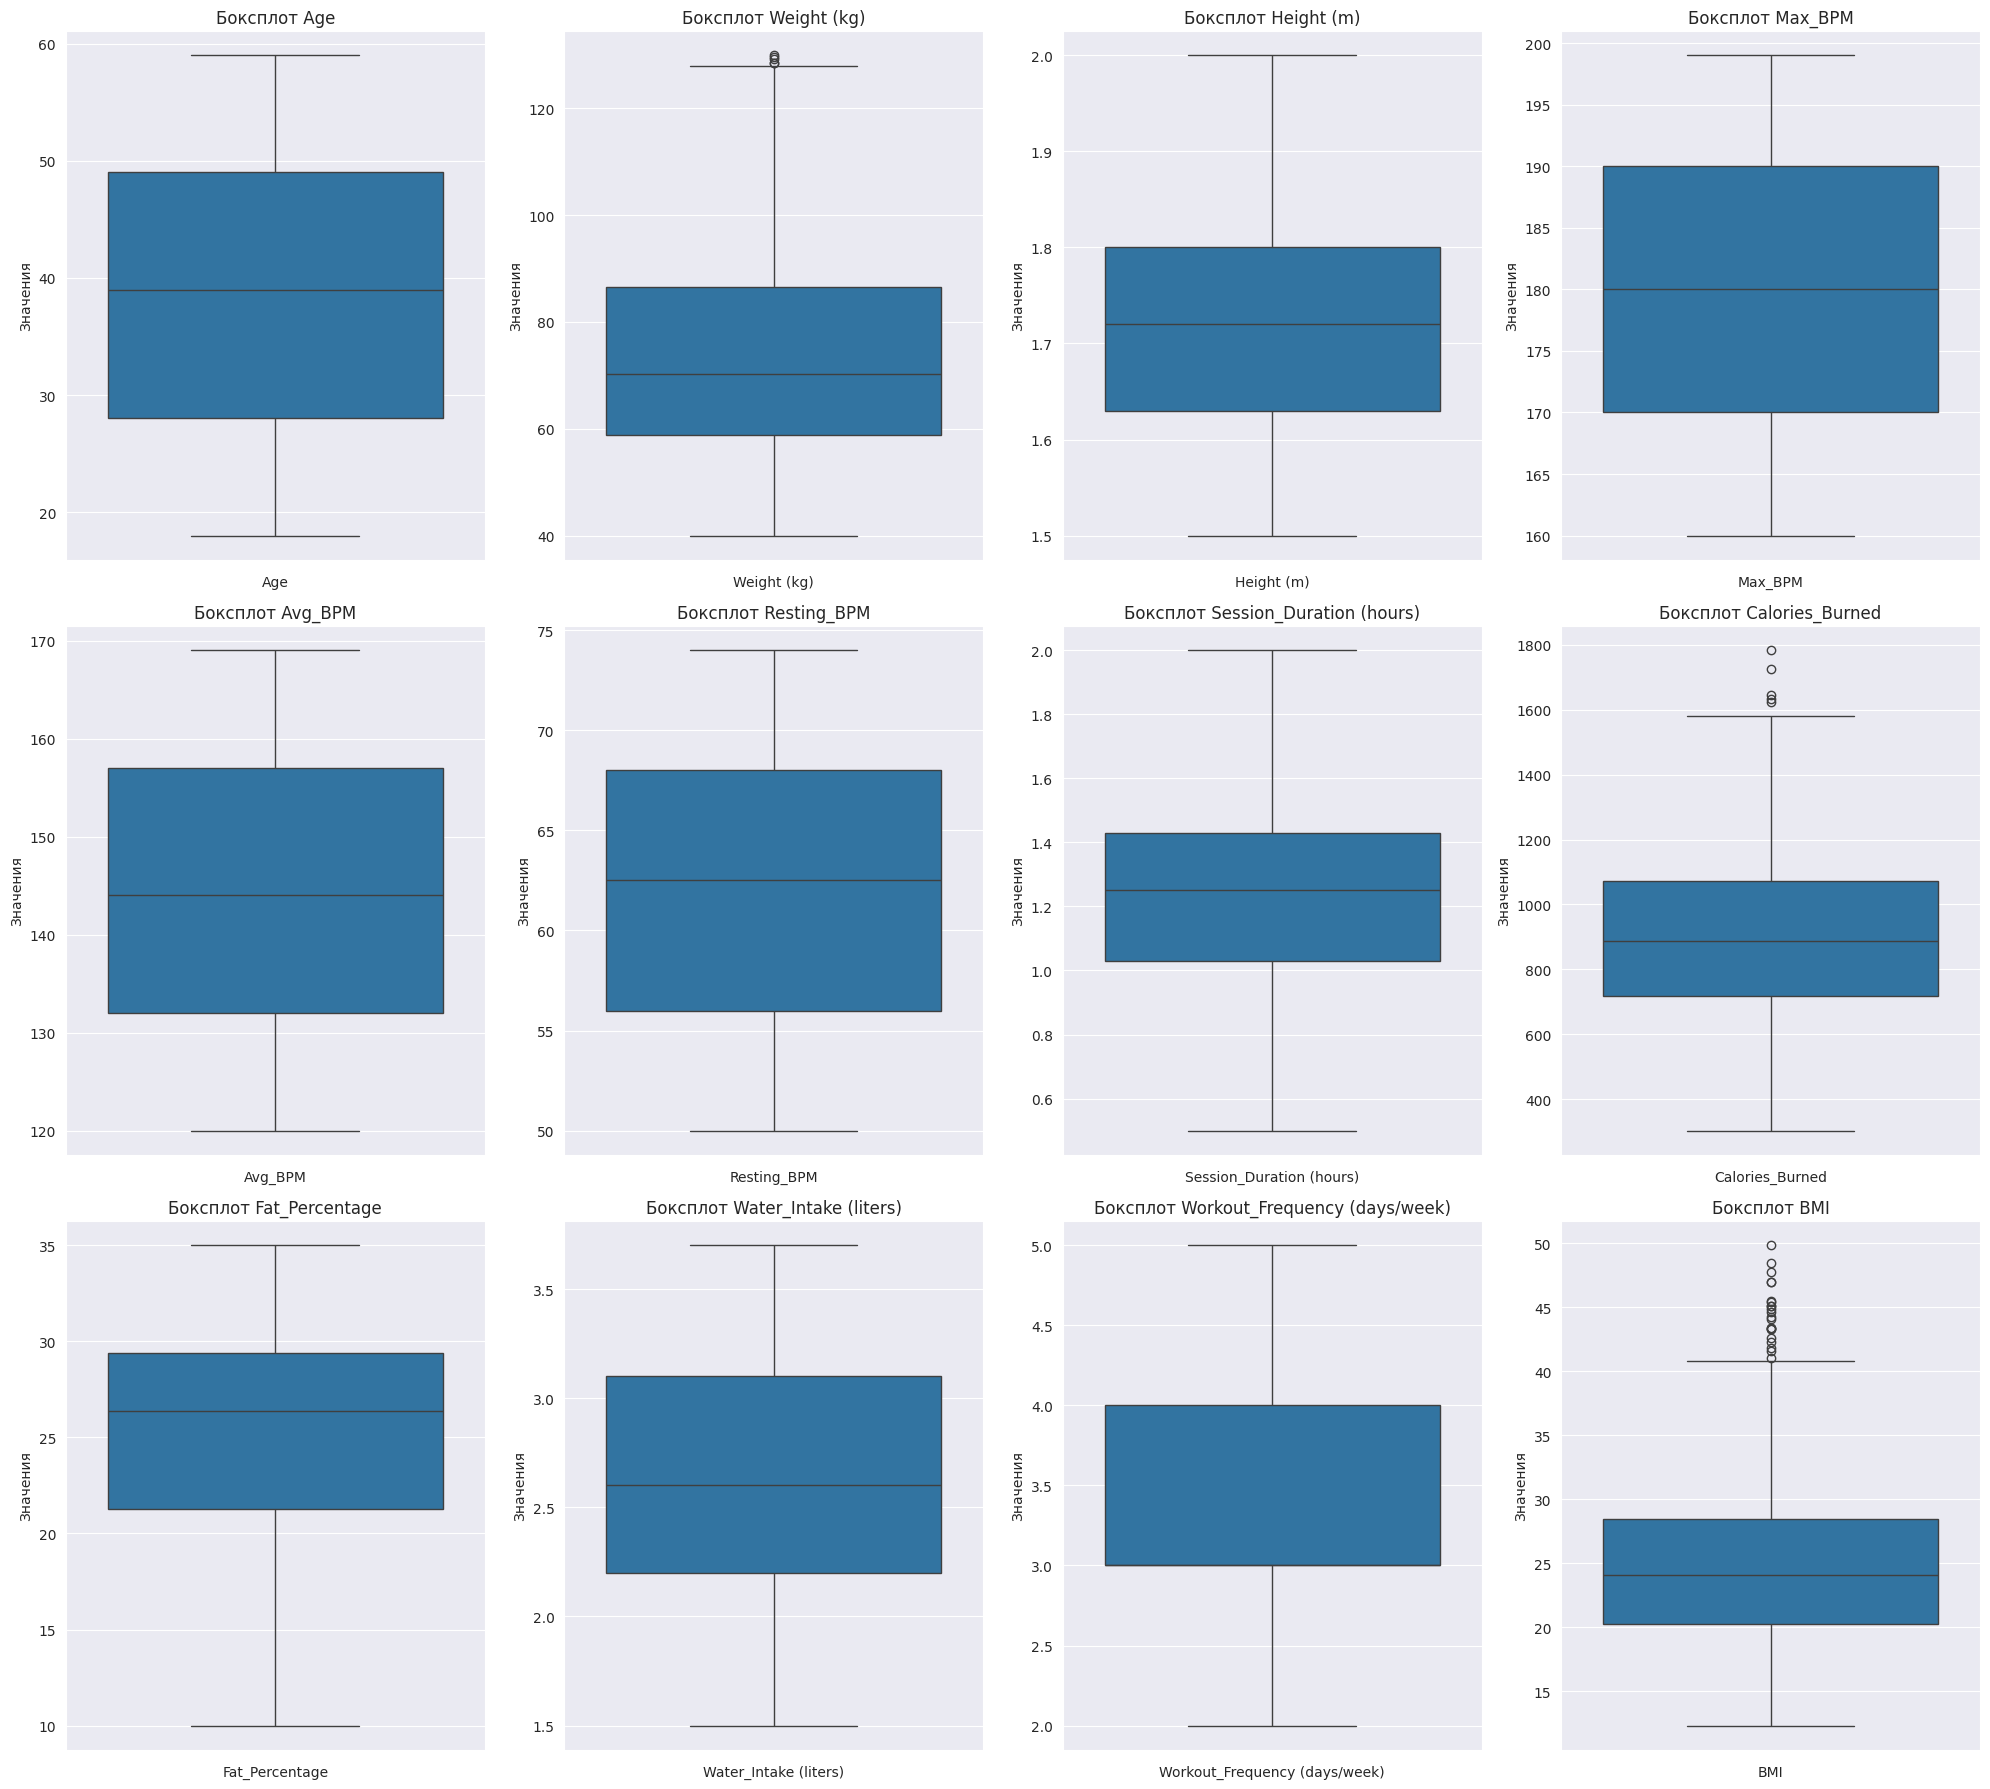

In [27]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    sns.boxplot(y=train[col], ax=axes[idx])
    axes[idx].set_title(f'Боксплот {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Значения')

for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

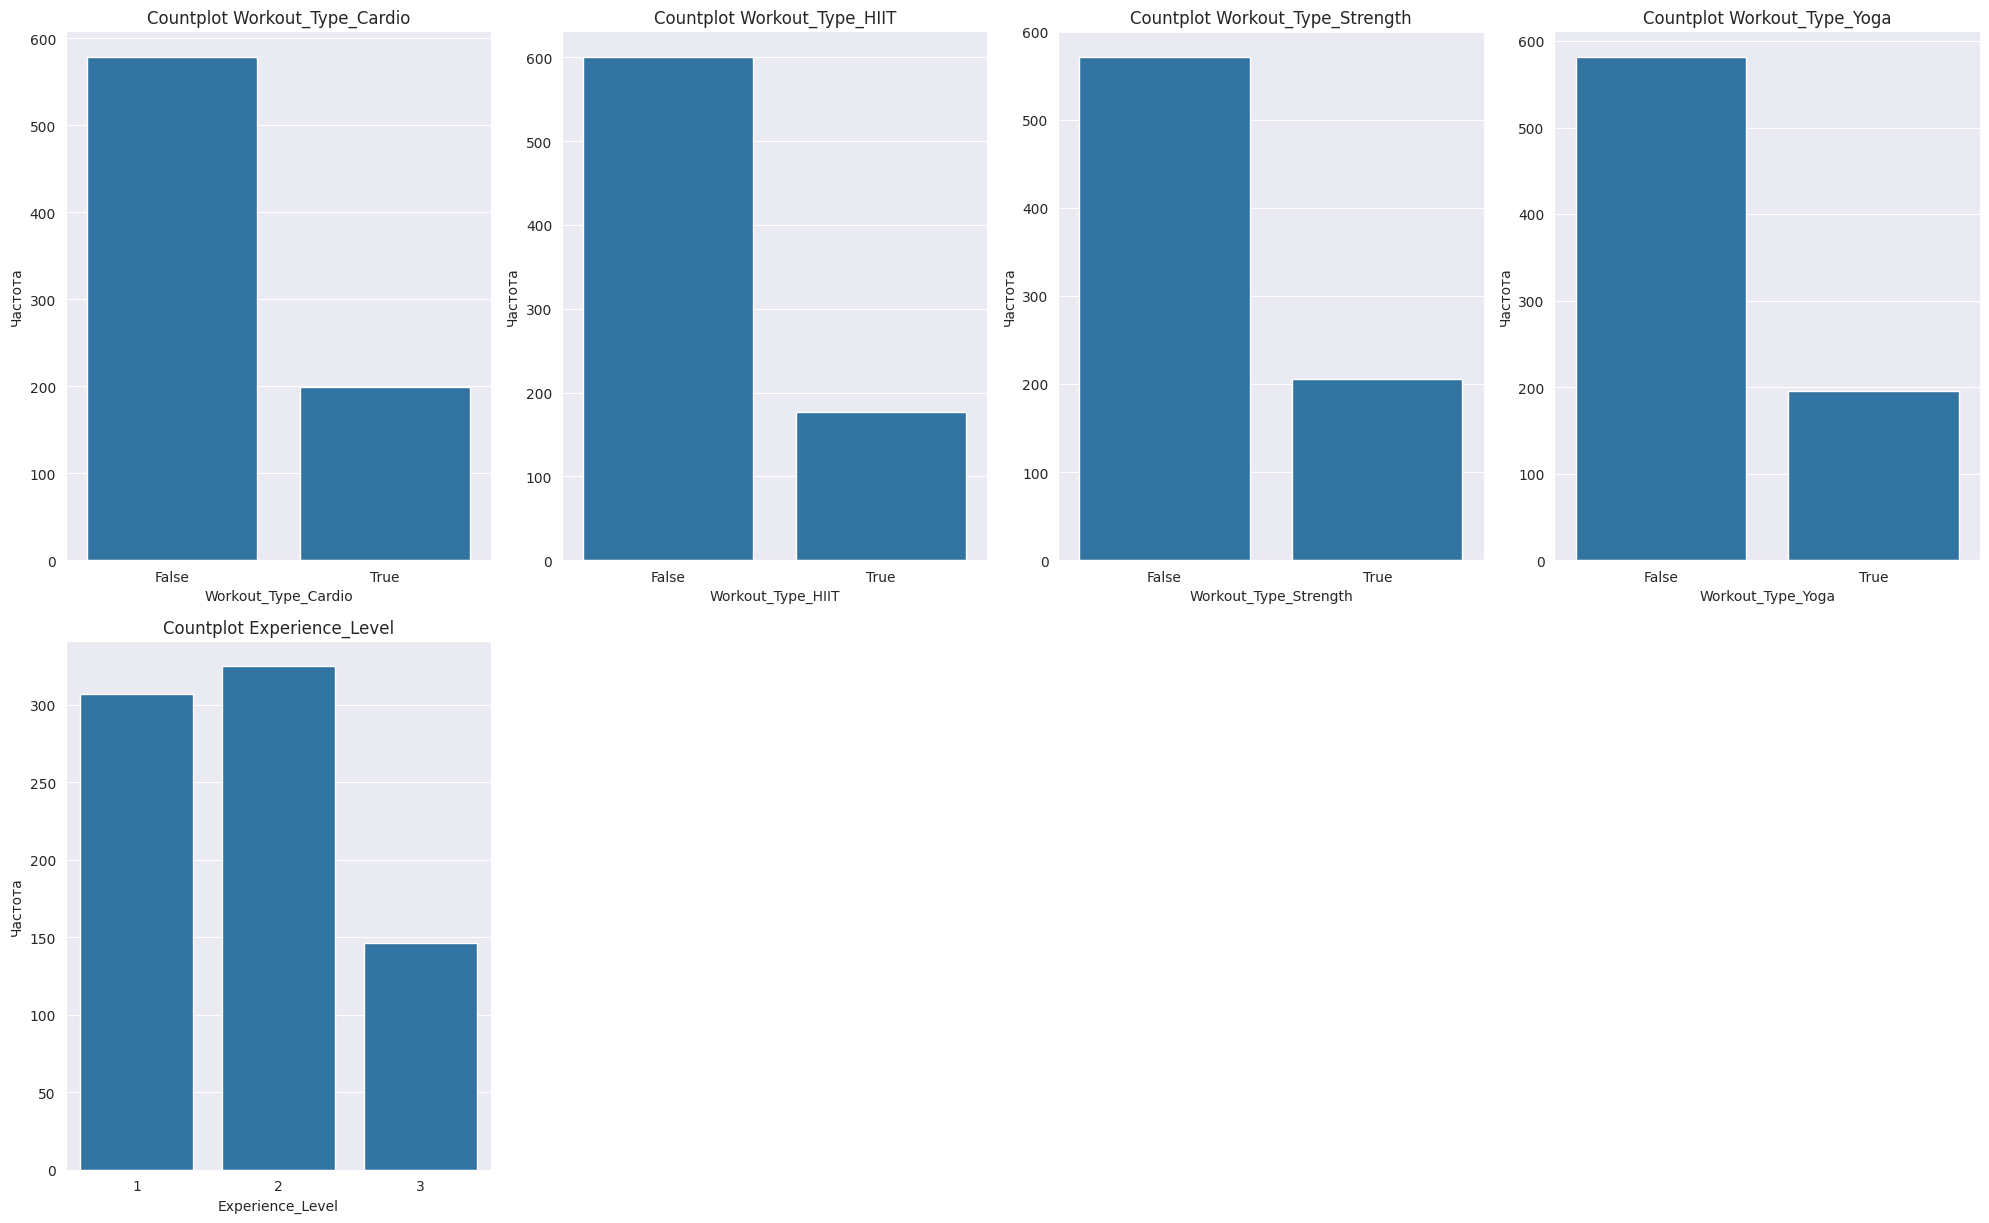

In [28]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

for idx, col in enumerate(categorical_columns):
    sns.countplot(x=train[col], ax=axes[idx])
    axes[idx].set_title(f'Countplot {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')

for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

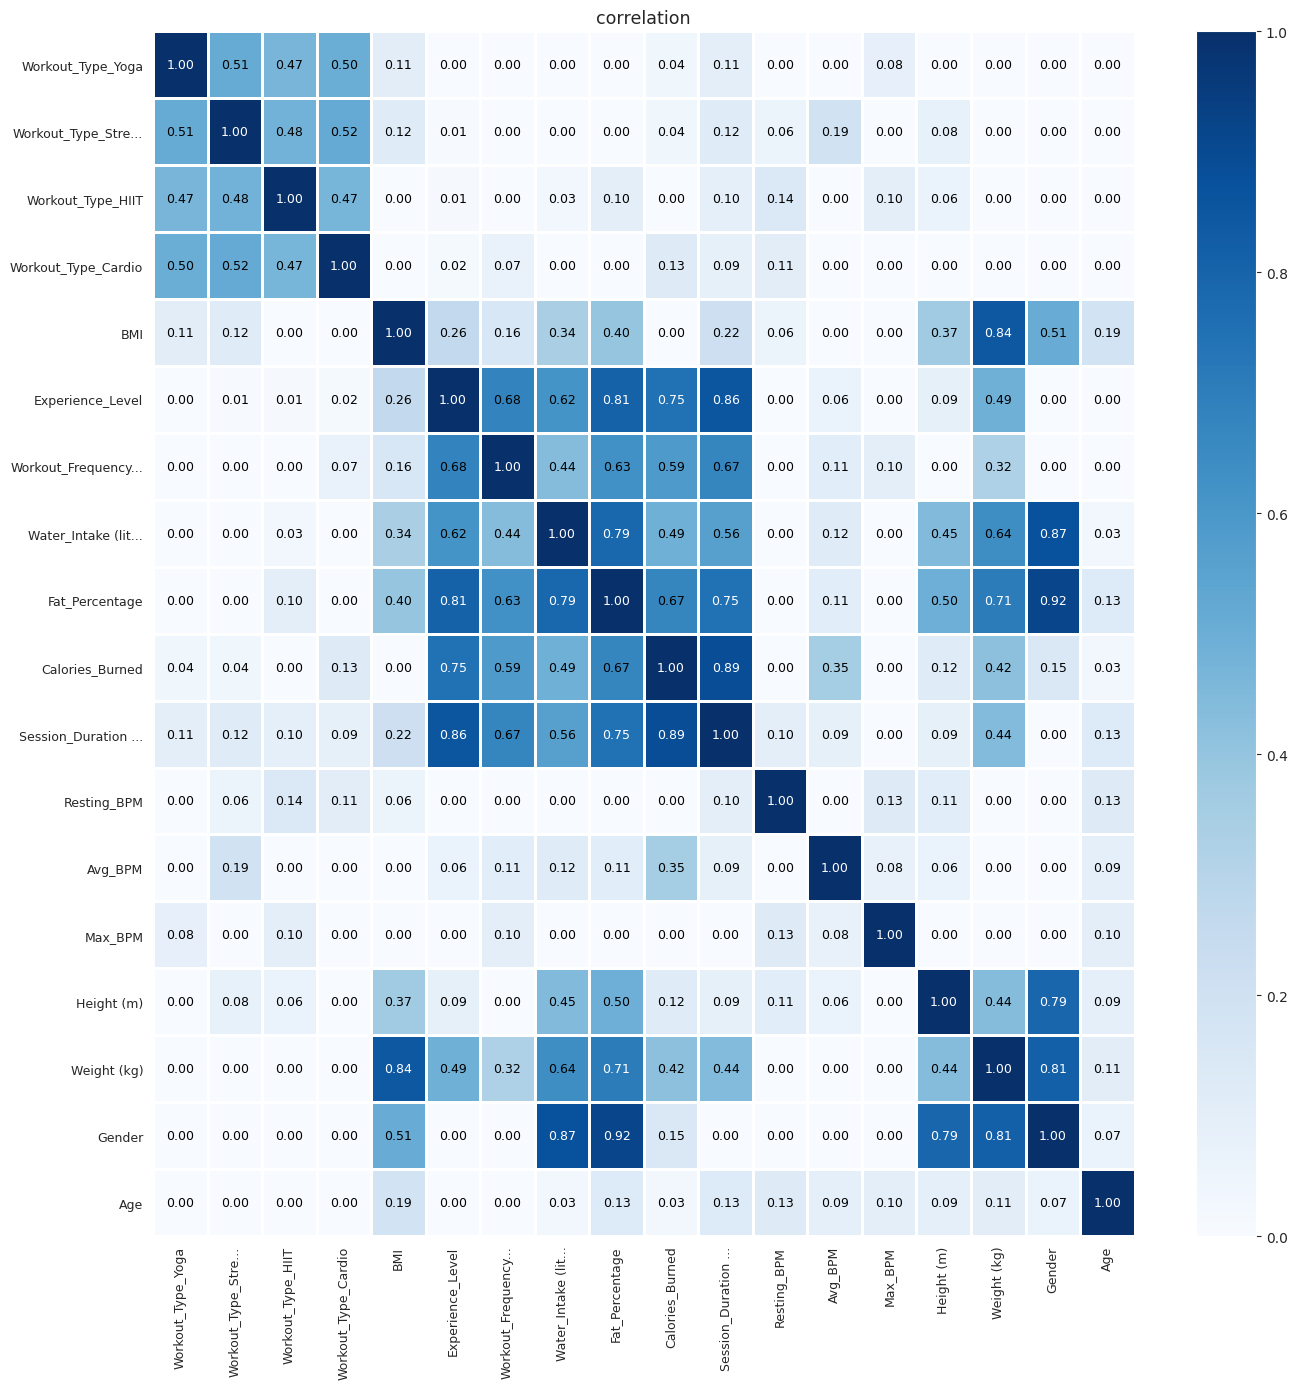

In [30]:
#3. Построение матрицы корреляции признаков
phik_overview = train.phik_matrix(interval_cols=numerical_columns)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"correlation",
                        fontsize_factor=0.9, figsize=(14, 14))
plt.tight_layout()

In [31]:
train.corr()

Age    Gender  Weight (kg)  Height (m)  \
Age                            1.000000  0.014515    -0.040006   -0.062051   
Gender                         0.014515  1.000000     0.585810    0.586487   
Weight (kg)                   -0.040006  0.585810     1.000000    0.382534   
Height (m)                    -0.062051  0.586487     0.382534    1.000000   
Max_BPM                       -0.042879  0.034767     0.075213    0.002295   
Avg_BPM                        0.027983  0.010663     0.023862   -0.019495   
Resting_BPM                    0.004092  0.006965    -0.047783   -0.024326   
Session_Duration (hours)      -0.037546 -0.031662    -0.041212    0.022040   
Calories_Burned               -0.168679  0.132976     0.076345    0.119081   
Fat_Percentage                 0.003756 -0.394089    -0.219903   -0.248291   
Water_Intake (liters)          0.044920  0.658822     0.393560    0.404503   
Workout_Frequency (days/week)  0.034825 -0.048727    -0.040537   -0.002818   
Experience_Level              -0.008183 -0.022294    -0.018586    0.011489   
BMI                            0.001718  0.327387     0.858901   -0.130848   
Workout_Type_Cardio           -0.052542 -0.009532     0.042688   -0.011133   
Workout_Type_HIIT              0.011634 -0.024869     0.017583   -0.026256   
Workout_Type_Strength          0.005458  0.015778    -0.036777   -0.003345   
Workout_Type_Yoga              0.036024  0.017560    -0.022504    0.039943   

                                Max_BPM   Avg_BPM  Resting_BPM  \
Age                           -0.042879  0.027983     0.004092   
Gender                         0.034767  0.010663     0.006965   
Weight (kg)                    0.075213  0.023862    -0.047783   
Height (m)                     0.002295 -0.019495    -0.024326   
Max_BPM                        1.000000 -0.039139     0.021997   
Avg_BPM                       -0.039139  1.000000     0.065789   
Resting_BPM                    0.021997  0.065789     1.000000   
Session_Duration (hours)      -0.005616  0.011420    -0.009349   
Calories_Burned               -0.006585  0.333653     0.022984   
Fat_Percentage                -0.005669 -0.013268    -0.014737   
Water_Intake (liters)          0.036889  0.007765    -0.006619   
Workout_Frequency (days/week) -0.040036 -0.020372     0.001884   
Experience_Level              -0.003665 -0.002408     0.017279   
BMI                            0.075287  0.041170    -0.037344   
Workout_Type_Cardio           -0.009701 -0.004737     0.001303   
Workout_Type_HIIT              0.008864 -0.024714     0.005777   
Workout_Type_Strength         -0.023411  0.024535     0.009943   
Workout_Type_Yoga              0.024983  0.003691    -0.016993   

                               Session_Duration (hours)  Calories_Burned  \
Age                                           -0.037546        -0.168679   
Gender                                        -0.031662         0.132976   
Weight (kg)                                   -0.041212         0.076345   
Height (m)                                     0.022040         0.119081   
Max_BPM                                       -0.005616        -0.006585   
Avg_BPM                                        0.011420         0.333653   
Resting_BPM                                   -0.009349         0.022984   
Session_Duration (hours)                       1.000000         0.910293   
Calories_Burned                                0.910293         1.000000   
Fat_Percentage                                -0.568019        -0.586206   
Water_Intake (liters)                          0.259898         0.336945   
Workout_Frequency (days/week)                  0.641156         0.562574   
Experience_Level                               0.758849         0.682970   
BMI                                           -0.053395         0.023237   
Workout_Type_Cardio                           -0.068297        -0.051422   
Workout_Type_HIIT                              0.060571         0.044499   
Workou

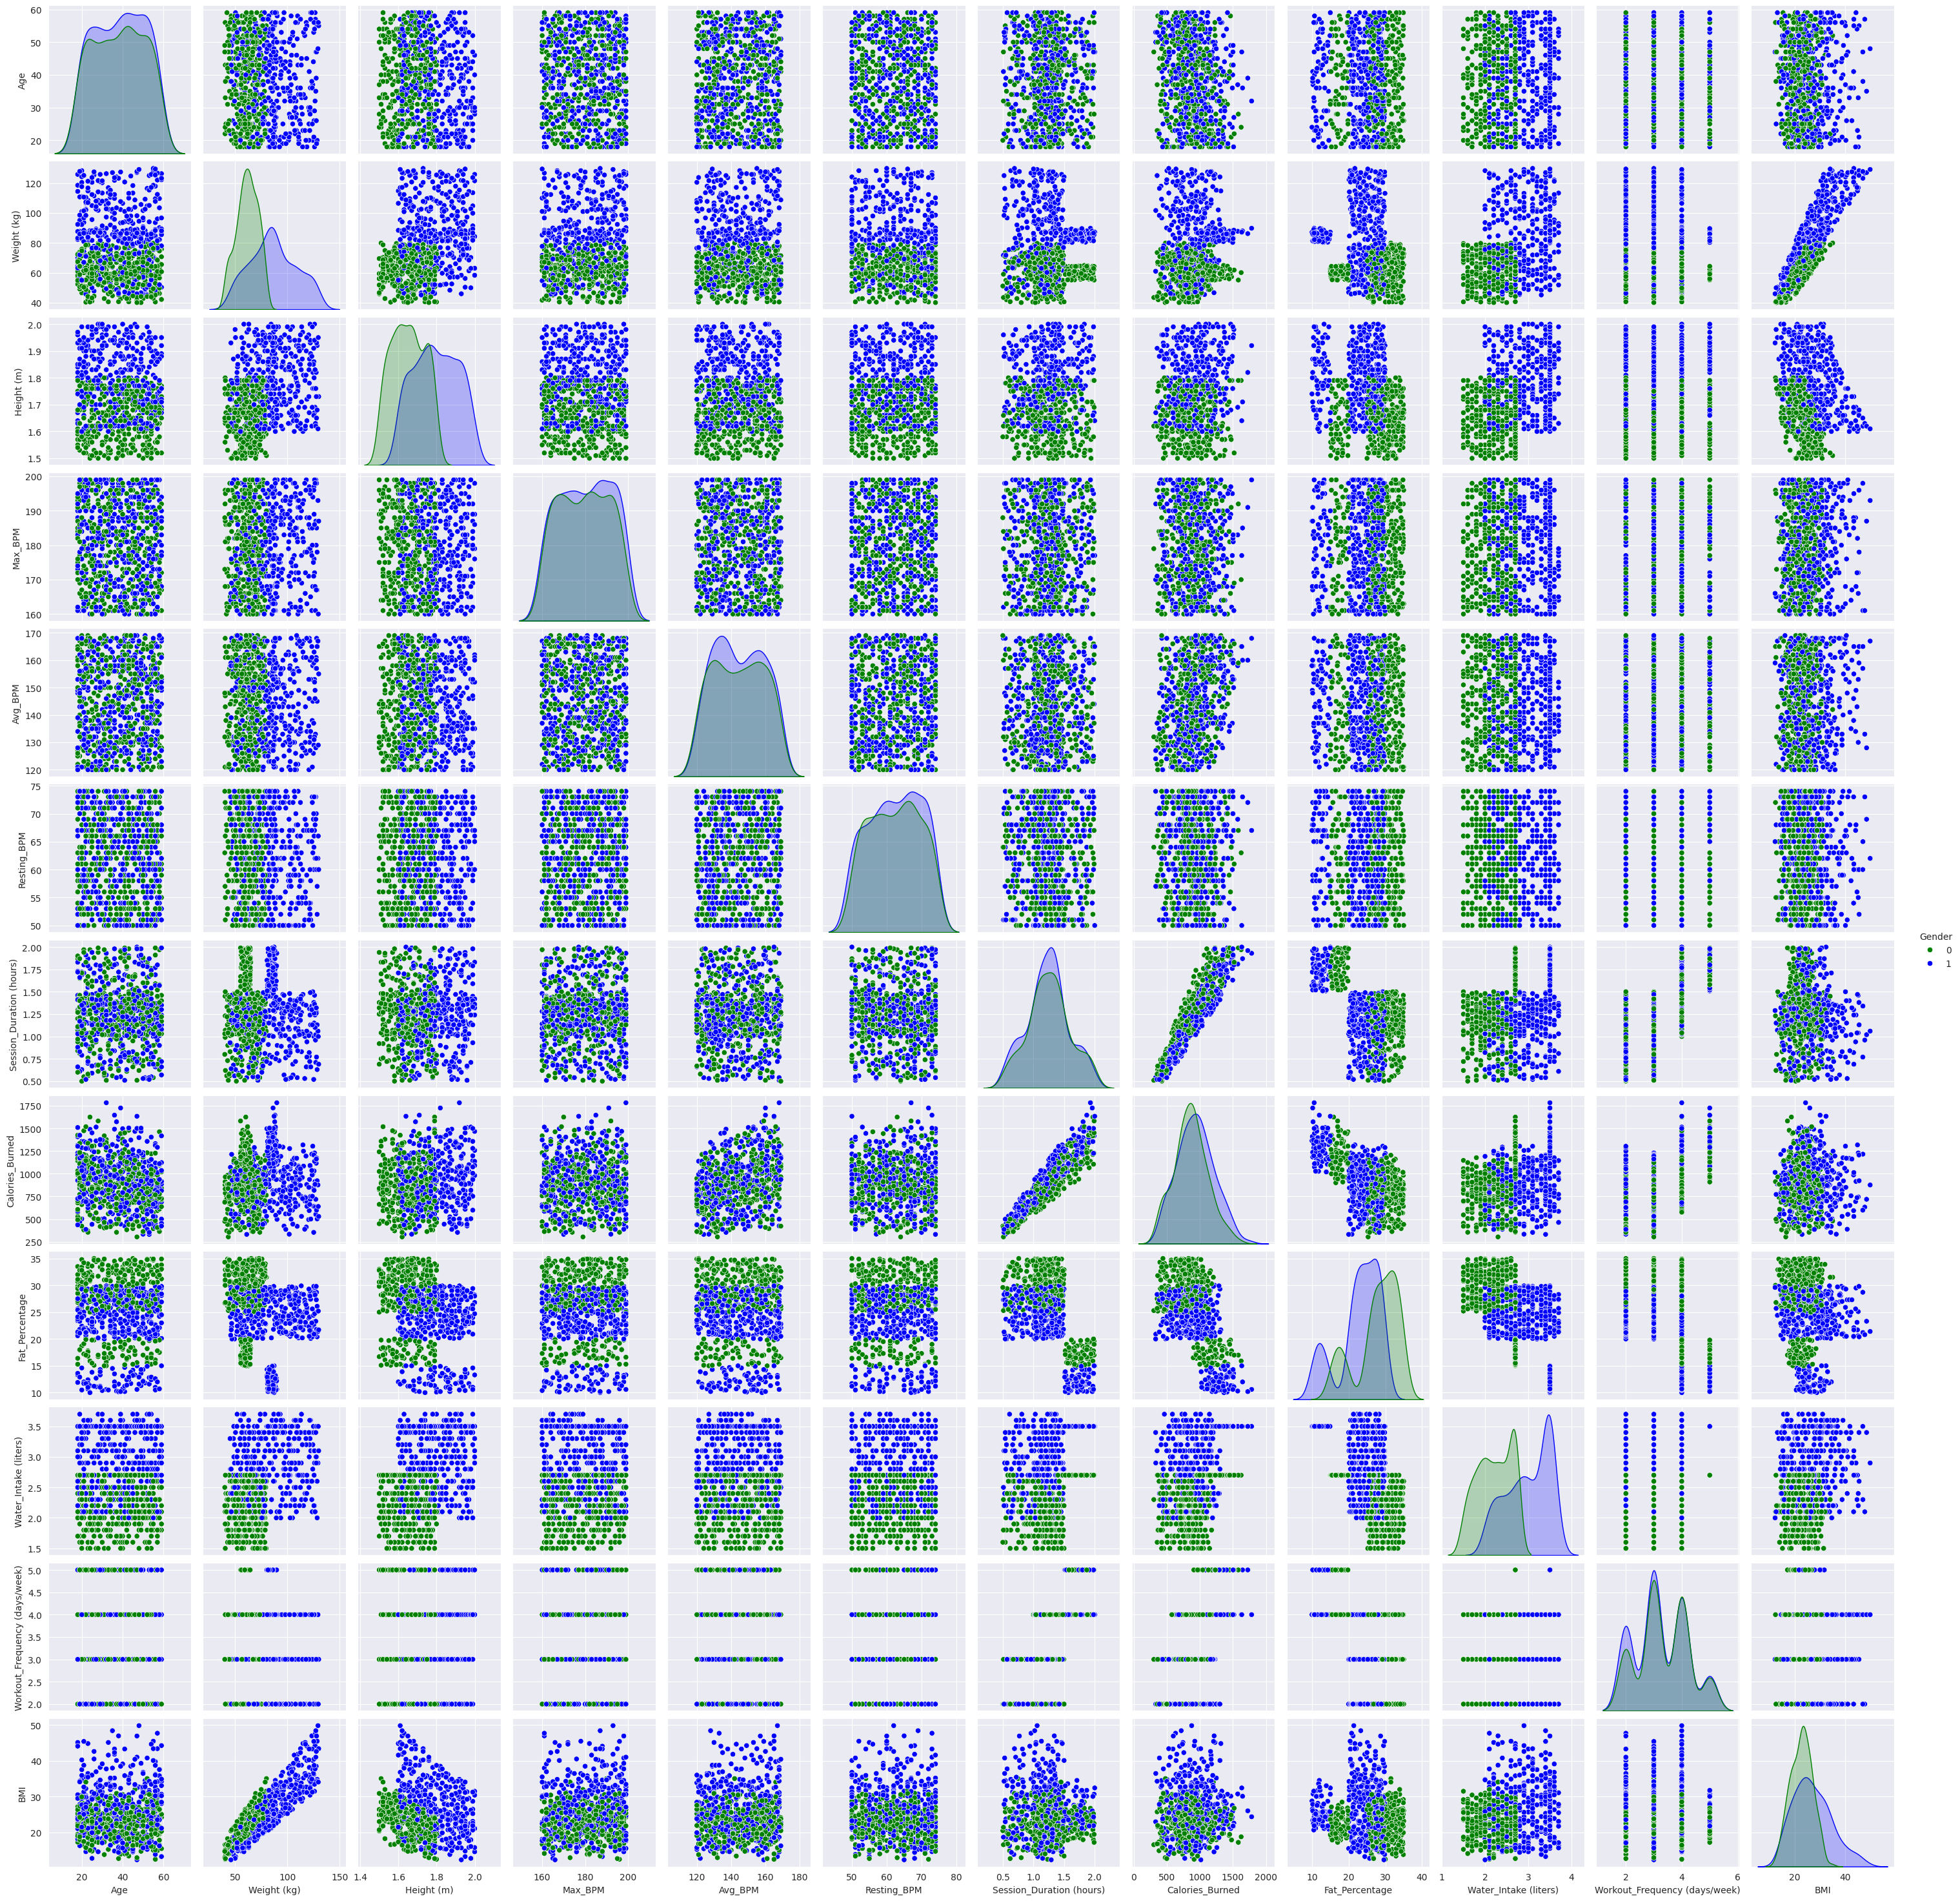

In [32]:
# 2. Построение pairplot
sns.pairplot(train, hue=target_columns, palette=['green', 'blue'])
plt.show()

### Вывод:
- Выбросы в BMI, весе и калориях играют важную роль, поэтому их не стоит удалять.
- Есть колонки, имеющие нулевую корреляцию с gender: их стоит удалить.
- Остальные колонки имеют высокую корреляцию, потому стоит оставить только их, те оставить только признаки, у которых корреляция больше 0.1.
- После удаления слабых признаков стоит подумать над корреляцией оставшихся фичей

### Удаление колонок, имеющих низкую корреляцию с таргетом

In [33]:
# Выбираем колонки с корреляцией с Gender > 0.1
filtered_columns = phik_overview.loc[phik_overview['Gender'] > 0.05, 'Gender'].index

# Формируем новый DataFrame с выбранными колонками
new_train = train[filtered_columns]

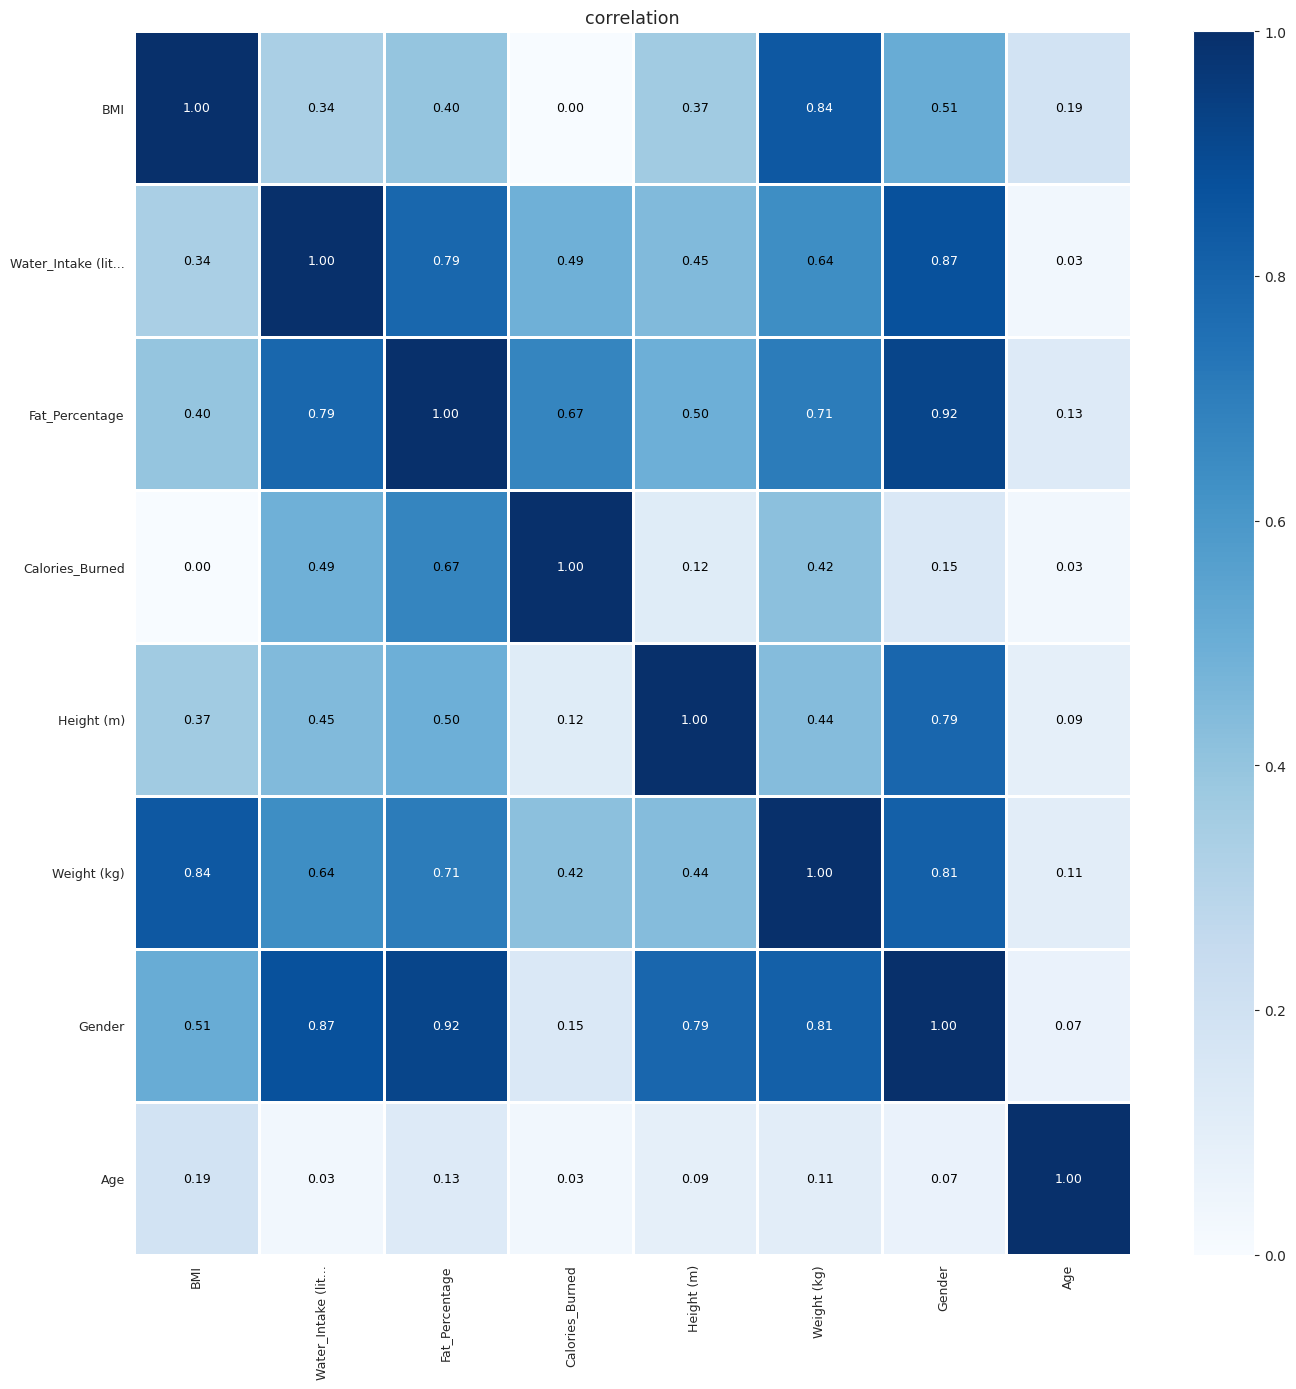

In [36]:
#3. Построение матрицы корреляции признаков
phik_overview = new_train.phik_matrix(interval_cols=numerical_columns)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"correlation",
                        fontsize_factor=0.9, figsize=(14, 14))
plt.tight_layout()

Как видим, высокая корреляция у признаков между собой, поэтому избавимся от нее

### Избавимся от корреляции

In [37]:
new_X_train = new_train.drop(columns=["Gender"], inplace=False)
new_y_train = new_train["Gender"]
new_valid = valid[filtered_columns]
new_X_valid = new_valid.drop(columns=["Gender"], inplace=False)
new_y_valid = new_valid["Gender"]

In [38]:
pca = PCA(n_components=len(filtered_columns)-1)
scaler = StandardScaler()
pca.fit(scaler.fit_transform(new_X_train))

PCA(n_components=7)

In [39]:
pca.explained_variance_ratio_

array([0.36380005, 0.22617939, 0.15163283, 0.14341653, 0.06766221,
       0.04644399, 0.000865  ])

Как видим, за 5 компонент можно почти описать все данные, потому оставим 4 компоненты

### Обучаем на новых данных

Также добавим нормировку, чтобы выбросы сильно не влияли на результаты

In [40]:
model = Pipeline((
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier())
))

In [41]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

Делаем предсказания по тренировочной выборке и валидационной

In [42]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### B: Оценка качества модели

In [43]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict)
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro')
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict)
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro')
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [44]:
metrics_df.head()

Метрика  Тренировочная выборка  Валидационная выборка
0                 F1                    1.0               0.990099
1  Balanced Accuracy                    1.0               0.990196
2          Precision                    1.0               0.989474
3             Recall                    1.0               0.990196

Визуализируем метрики

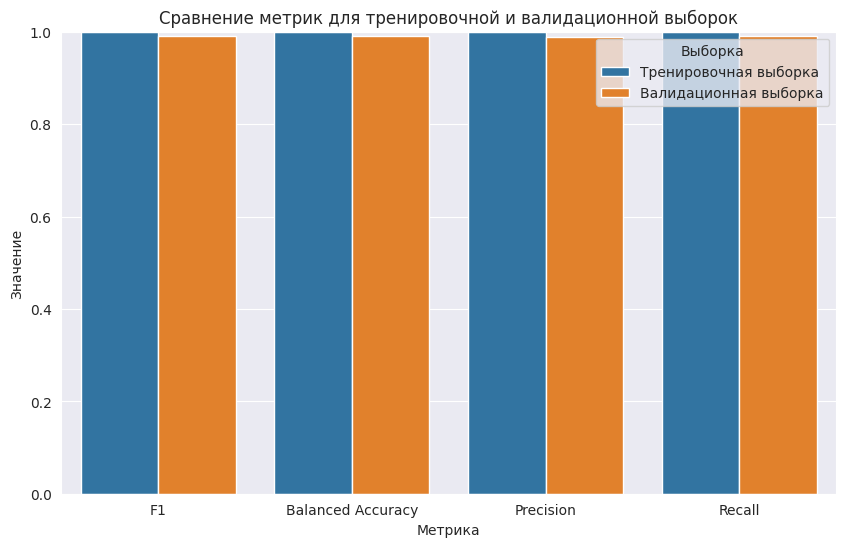

In [45]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

Отлично, результат сильно лучше, но хуже чем у k ближайших!

## Импортируем собственную реализацию модели ближайших соседей

In [46]:
from implementation import MyRandomForestClassifier

### Обучаем модель

In [47]:
model = RandomForestClassifier()

In [48]:
model.fit(X_train, y_train)

RandomForestClassifier()

Делаем предсказания по тренировочной выборке и валидационной

In [49]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### B: Оценка качества модели

In [50]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict)
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro')
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict)
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro')
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [51]:
metrics_df.head()

Метрика  Тренировочная выборка  Валидационная выборка
0                 F1                    1.0               0.990099
1  Balanced Accuracy                    1.0               0.990196
2          Precision                    1.0               0.989474
3             Recall                    1.0               0.990196

Визуализируем метрики

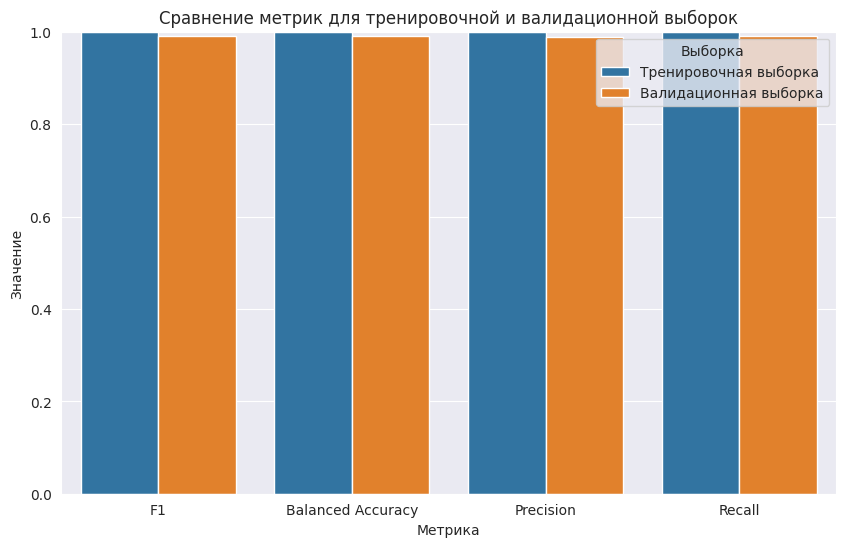

In [52]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Обучаем с улучшенным бейзлайном

In [53]:
model = Pipeline((
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier())
))

In [54]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

Делаем предсказания по тренировочной выборке и валидационной

In [55]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### B: Оценка качества модели

In [56]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict)
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro')
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict)
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro')
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [57]:
metrics_df.head()

Метрика  Тренировочная выборка  Валидационная выборка
0                 F1                    1.0               0.995074
1  Balanced Accuracy                    1.0               0.995098
2          Precision                    1.0               0.994681
3             Recall                    1.0               0.995098

Визуализируем метрики

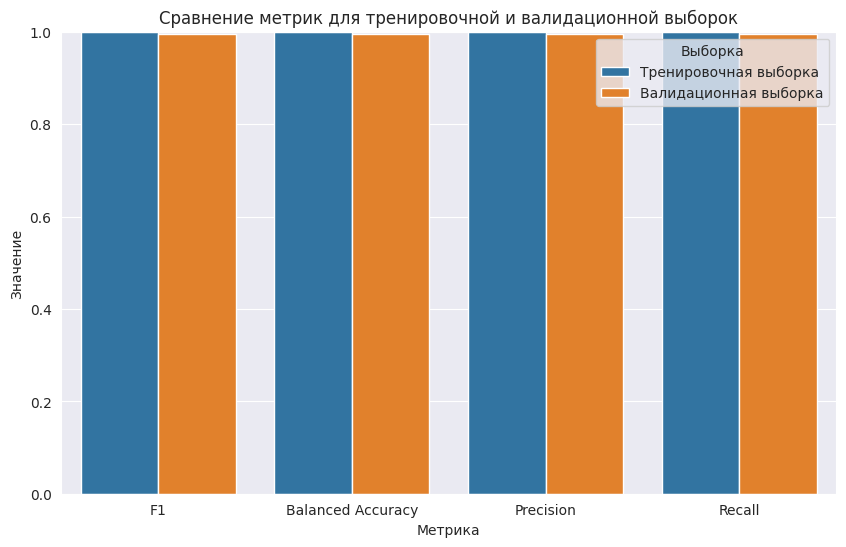

In [58]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

## Вывод:
Как видим, модель, написанная мною работает не сильно хуже модели sklearn.